# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. 

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [32]:
# Run some setup code for this notebook.

from __future__ import print_function

import random
import numpy as np
from dl01ec.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'dl01ec/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


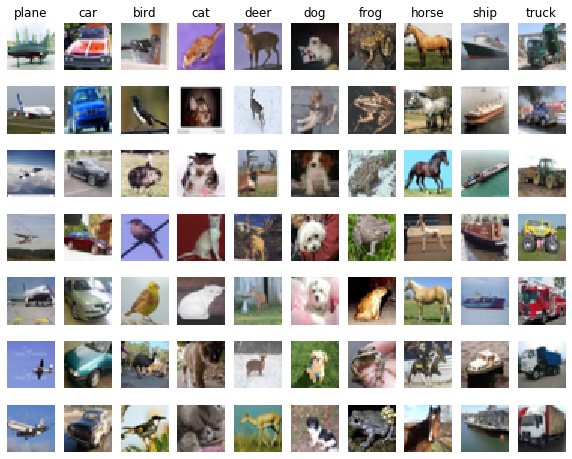

In [34]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [35]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [36]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [37]:
from dl01ec.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
print(X_train[1])
print(y_train[1])
print(X_train[10])
print(y_train[10])
print(X_train[100])
print(y_train[100])
print(X_train[4999])
print(y_train[4999])

[154. 177. 187. ... 143. 133. 144.]
9
[53. 65. 53. ... 49. 50. 41.]
4
[213. 229. 242. ... 228. 228. 226.]
8
[ 45.  32.  21. ... 156. 142. 100.]
6


We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `dl01ec/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [39]:
# Open dl01ec/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)

# Print the dimensions of the distance matrix
print(dists.shape)

# Print the computed distances from the 0th row of the distance matrix
print(dists[0,:])

(500, 5000)
[3803.92350081 4210.59603857 5504.0544147  ... 4007.64756434 4203.28086142
 4354.20256764]


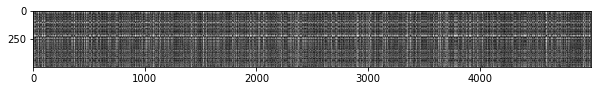

In [40]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Our Answer**: We have used 500 test samples and 5000 training samples for this exercise. We then found the euclidean distance for each test sample with each training sample. Each row in the distance matrix represents the distances for each test sample with 5000 training samples. As white colour indicates high distances and black colour indicates indicates low distances:

**A bright row** means that the test data sample in that particular row does not match with most of the 5000 training data samples against which it has been compared, as the test data sample has longer distance with all training data samples.

**A bright column** means that the training data sample in that particular column does not match with most of the 500 test data samples against which it has been compared, as the training data sample has longer distance with all test data samples.

In [41]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [42]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

Now lets try out k = 6:

In [43]:
y_test_pred = classifier.predict_labels(dists, k=6)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


**Our Observations**: The performance has further improved with an accuracy around 28%. But the performance was found to go down when k was given values of 7, 8 and 9. But for k=10, the performance was same as k=6. The performance was found to go down again for k > 10.

**Inline Question 2**
We can also other distance metrics such as L1 distance.
The performance of a Nearest Neighbor classifier that uses L1 distance will not change if (Select all that apply.):
1. The data is preprocessed by subtracting the mean.
2. The data is preprocessed by subtracting the mean and dividing by the standard deviation.
3. The coordinate axes for the data are rotated.
4. None of the above.

**Our Answer**: Options 1 and 2

**Explanation**: The distances between the data points, while using L1 distance, do not change on subtracting the mean because every data point shifts in the same direction by the same amount. Hence preprocessing of data by subtracting the mean does not change the performance of the NN classifier.

In option two, the additional preprocessing step that is done is to scale the data by dividing with the standard deviation. Then the distances between the points are all scaled by the same amount which means that the biggest distances remain the biggest distances after scaling. Hence the preprocessing of data by subtracting the mean and dividing by the standard deviation also does not change the performance of the NN classifier.

The L1 distance (Manhattan Distance) between two data point is calculated by summing up the distance traversed along each axis from one point to another. Hence when axes are rotated, this distance will change. So, the performance of K-Nearest Neighbor with L1 distance will change when axes are rotated. But it may be noted that in the case of L2 distance it is the Euclidean Distance between the points, which does not change when the axes are rotated as the points do not change relative to each other.

In [44]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# Print the dimensions of the distance matrix
print(dists_one.shape)

# Print the computed distances from the 0th row of the distance matrix
print(dists_one[0,:])

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

(500, 5000)
[3803.92350081 4210.59603857 5504.0544147  ... 4007.64756434 4203.28086142
 4354.20256764]
Difference was: 0.000000
Good! The distance matrices are the same


In [45]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# Print the dimensions of the distance matrix
print(dists_one.shape)

# Print the computed distances from the 0th row of the distance matrix
print(dists_one[0,:])

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

(500, 5000)
[3803.92350081 4210.59603857 5504.0544147  ... 4007.64756434 4203.28086142
 4354.20256764]
Difference was: 0.000000
Good! The distance matrices are the same


In [46]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

KeyboardInterrupt: 

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [47]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# The training data array and the corresponding label array are split into sub arrays
# based on num_folds and store these arrays in arrays X_train_folds and y_train_folds.
# The numpy.array_split function splits an array into multiple sub-arrays of equal
# or near-equal size. It is preferred here, as unlike the numpy.split function,
# it does not raise an exception if an equal division cannot be made.
X_train_folds = np.array(np.array_split(X_train, num_folds))
y_train_folds = np.array(np.array_split(y_train, num_folds))
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# The approach taken here for cross validation for each k value is to cycle through
# all the folds by making one fold as the validation data set and combining the
# other folds to form the training data set for the cycle
for k in k_choices:
    k_to_accuracies[k] = [0] * num_folds
    for test_index in range(num_folds):
        # Exclude the fold with index 'test_index' and combine the remaining folds
        # to create the training data set for cross validation.
        X_train_cv = np.concatenate([fold_data for fold_index,fold_data in 
                                     enumerate(X_train_folds) if fold_index != test_index])
        y_train_cv = np.concatenate([fold_data for fold_index,fold_data in
                                     enumerate(y_train_folds) if fold_index != test_index])
        
        # Use the fold excluded from the training data set as the cross
        # validation test data set.
        X_test_cv = X_train_folds[test_index]
        y_test_cv = y_train_folds[test_index]
        
        # Train using the cross validation training data set and Predict
        # the labels based on the cross validation test data set using 
        # the prediction function which does not use loops.
        classifier.train(X_train_cv, y_train_cv)
        dists = classifier.compute_distances_no_loops(X_test_cv)
        y_test_pred_cv = classifier.predict_labels(dists, k)
        
        # Determine the number of correct predictions, calculate the accuracy
        # of predictions and store it in k_to_accuracies dictionary
        num_correct = np.sum(y_test_pred_cv == y_test_cv)
        k_to_accuracies[k][test_index] = float(num_correct) / len(y_test_cv)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))


X_train_folds.shape:  [[[ 59.  62.  63. ... 123.  92.  72.]
  [154. 177. 187. ... 143. 133. 144.]
  [255. 255. 255. ...  80.  86.  84.]
  ...
  [145. 148. 157. ... 126. 160.  91.]
  [146. 146. 146. ... 238. 238. 238.]
  [203. 206. 208. ... 132. 131. 126.]]

 [[242. 243. 250. ... 105. 123. 135.]
  [ 56.  50.  28. ... 131. 112.  86.]
  [100.  86.  89. ...  44.  49.  48.]
  ...
  [ 41.  47.  35. ... 161. 149.  89.]
  [ 66. 101. 131. ... 171. 176. 186.]
  [124. 190. 225. ... 138. 145. 110.]]

 [[255. 255. 247. ...  53.  52.  45.]
  [119. 103.  92. ...  95. 113. 126.]
  [255. 255. 255. ... 159. 160. 164.]
  ...
  [ 29.  32.  32. ... 212. 215. 207.]
  [171. 151. 119. ... 166. 147. 117.]
  [213. 219. 244. ...  52.  54.  44.]]

 [[254. 254. 254. ... 217. 215. 213.]
  [175. 247. 159. ... 110. 110. 136.]
  [ 91.  67.  69. ...   5.   2.   3.]
  ...
  [164. 150. 127. ... 161. 138. 103.]
  [228. 236. 240. ...  92. 105. 113.]
  [ 90. 109.  89. ...  83. 153.  57.]]

 [[ 86. 138. 179. ...  75. 123. 16

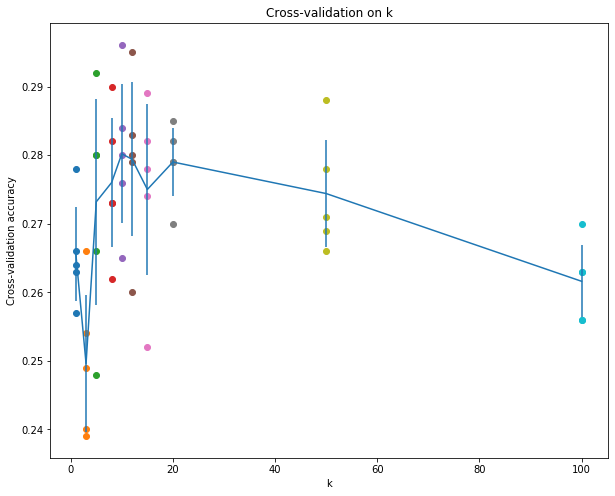

In [22]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [23]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


**Inline Question 3**
Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The training error of a 1-NN will always be better than that of 5-NN.
2. The test error of a 1-NN will always be better than that of a 5-NN.
3. The decision boundary of the k-NN classifier is linear.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

**Our Answer**: Options 1 and 4 are true about k-Nearest Neighbour

**Explanation**: For a k-NN classifier, the bias of the 1-nearest neighbor estimate is often low, but the variance is high. The bias is low, because the model is fit only to the 1-nearest point. This means the model will be really close to the training data. The variance is high because optimizing on only 1-nearest point means that the probability of noise in the data influencing the model is very high. But as the value of k goes up, k number of nearest points to the query points are consider and hence the bias increases and as the probability of noise influencing the data is reducing, the variance decreases. Training error increases and test error decreases as the value of k goes up. Hence training error of a 1-NN will always be better than that of 5-NN. *But it may be noted that the test error takes an inverted U shape as k increases, indicating that the test error starts increasing after a certain value of k*

A classifier is linear if its decision boundary on the feature space is a linear function, i.e., positive and negative data points are separated by a hyperplane. In the case of k-NN, generally the decision boundary on the feature space will look more like a curve than a hyperplane. Hence, in general, k-NN is considered to be a non-linear classifier.

k-NN is a memory or instance based learning as it simply memorizes all examples in the training data set and then compares the test data set with them. The time for testing grows linearly w.r.t the size of the training set as we need to compute the distance of each training data element from the test data element. Hence in k-NN, large training sets come with a significant increase in execution time to classify a test example.